In [2]:
#load in the libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, plot_partial_dependence
from matplotlib.pyplot import figure
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from statistics import mean
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from nested_cv import NestedCV
from IPython.display import Image
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.inspection import PartialDependenceDisplay
import pickle

#ignore warnings if you want
import warnings
warnings.filterwarnings("ignore")

In [3]:
#make function to match the status for what ever parasite it is, binarize it, and drop unnecessary columns
def gettrain(df, parasite):
    #matching the sandfly status for the species of parasite to the sandfly in the larger dataframe
    for j in range(len(df)):
        for i in range(len(status)):
            if df.loc[j, 'species'] == status.loc[i, 'species']:
                df.loc[j, parasite] = status.loc[i, parasite]
    #fill the remaining vector status column with 0s, then binarize the status
    df[parasite] = df[parasite].fillna(0).map(lambda x : x//2)
    #set the index as the species name
    train = df.set_index('species')
    #drop unnecessary columns
    train = train.drop(columns=['Unnamed: 0', '.imp', '.id'])
    if 'index' in df.columns:
        train = train.drop(columns=['index'])
    
    return train

In [4]:
def getstatus(df, parasite):
    for i in range(len(status)):
        for j in range(len(df)):
            if status.loc[i, 'species'] == df.loc[j, 'species']:
                df.loc[j, 'potential/proven'] = status.loc[i, parasite]
    df = df.fillna(0)
    return df

In [ ]:
original = pd.read_csv('raw data/vector trait data final.csv')
original = original.drop(columns=['Argentina', 'Belize','Bolivia', 'Brazil', 'Canada', 'CaymanIslands', 'Chile', 'Colombia', 'Costa.Rica', 'Cuba', 'Dominican.Republic', 'Ecuador', 'El.Salvador', 'French.Guiana','Guadeloupe', 'Guatemala', 'Grenada', 'Guyana', 'Haiti', 'Honduras', 'Jamaica','Martinica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay','PuertoRico', 'Peru', 'Suriname', 'TrinidadTobago', 'Uruguay', 'USA', 'Venezuela','VirginIslands'])
status = pd.read_csv('raw data/sandfly status.csv')
#if sandfly is a proven vector for any species of leish, mark it in a new column 'cl' as 1
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 1

#get cleaned train datasets in a list
parasite = 'leish'
for j in range(len(original)):
    for i in range(len(status)):
        if original.loc[j, 'species'] == status.loc[i, 'species']:
            original.loc[j, parasite] = status.loc[i, parasite]

#fill the remaining vector status column with 0s, then binarize the status
original[parasite] = original[parasite].fillna(0).map(lambda x : x//2)
#set the index as the species name
original = original.set_index('species')
#drop unnecessary columns
original_clean = original.drop(columns=['Unnamed: 0'])

####LOOK AT CORRELLATED VARIABLES
#tribe_Hertigiini is corr w 'genus_Warileya'
#subtribe_hertigiina is corr w 'genus_Warileya'
#peri is corr w semi.domestic
#'genus_Brumptomyia' is corr w 'subtribe_Brumptomyiina'
#'genus_Micropygomyia' is corr w 'subtribe_Sergentomyiina'

#wing_width / hs.canopy
#wing_width / hs.floor
#labruml_wingl / log.labrum.length
#log.grass.cover / log.shrub.cover
#domestic / intra
#wing.width/temp 
#log.elevation / temp
#log.temp.var / temp.range
#maxshape_sabre / genus_Brumptomyia
#log.dental.depth / log.labrum.length


In [10]:
coverage = original.isna().sum()
cov_df = pd.DataFrame(coverage)
cov_df[0] = (512 - cov_df[0])/512
cov_df.to_csv("no bites man/primary model/trait coverage.csv")

## no cutoff

In [11]:
original = pd.read_csv('raw data/all trait data and encoded.csv')
original = original.drop(columns=['Argentina', 'Belize','Bolivia', 'Brazil', 'Canada', 'CaymanIslands', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominican Republic', 'Ecuador', 'El Salvador', 'French Guiana','Guadeloupe', 'Guatemala', 'Grenada', 'Guyana', 'Haiti', 'Honduras', 'Jamaica','Martinica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay','PuertoRico', 'Peru', 'Suriname', 'TrinidadTobago', 'Uruguay', 'USA', 'Venezuela','VirginIslands'])
status = pd.read_csv('raw data/sandfly status.csv')
#if sandfly is a proven vector for any species of leish, mark it in a new column 'cl' as 1
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 1

#get cleaned train datasets in a list
parasite = 'leish'
for j in range(len(original)):
    for i in range(len(status)):
        if original.loc[j, 'species'] == status.loc[i, 'species']:
            original.loc[j, parasite] = status.loc[i, parasite]

#fill the remaining vector status column with 0s, then binarize the status
original[parasite] = original[parasite].fillna(0).map(lambda x : x//2)
#set the index as the species name
original = original.set_index('species', drop=True)
#drop unnecessary columns
original = original.drop(columns=['Unnamed: 0', 'bites.man', 'order.notes'])

####LOOK AT CORRELLATED VARIABLES
#tribe_Hertigiini is corr w 'genus_Warileya'
#subtribe_hertigiina is corr w 'genus_Warileya'
#peri is corr w semi.domestic
#'genus_Brumptomyia' is corr w 'subtribe_Brumptomyiina'
#'genus_Micropygomyia' is corr w 'subtribe_Sergentomyiina'

#wing_width / hs.canopy
#wing_width / hs.floor
#labruml_wingl / log.labrum.length
#log.grass.cover / log.shrub.cover
#domestic / intra
#wing.width/temp 
#log.elevation / temp
#log.temp.var / temp.range
#maxshape_sabre / genus_Brumptomyia
#log.dental.depth / log.labrum.length

original_clean = original.drop(columns=['subtribe_Sergentomyiina', 'subtribe_Brumptomyiina',
                                              'peri', 'subtribe_Hertigiina', 'tribe_Hertigiini',
                                              'wing.width', 'labruml_wingl', 'shrub.cover',
                                              'intra', 'elevation', 'temp.var', 'maxshape_sabre', 'dental.depth'])


In [7]:
# think i have to redo the one hot encoding
# tribe, subtribe, genus, max.shape, hypo.teeth
no_cutoff = original_clean

In [32]:
## From the hyperopt docs

from hyperopt import hp
from hyperopt import fmin, tpe
'''
## For the argument named 'a', choose either of the two tuples, each of which has a second
## argument drawn from a given distribution and given a name ('c1'/'c2')
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

'''
###TRY TO GET THE AUC, CHANGE THE THRESHHOLD PROBABILITY

def val_test(best, train_x, train_y, val_x, val_y, graph=False):
    params = {'max_depth': int(best['max_depth']), 'gamma': best['gamma'],
                  'learning_rate': best['learning_rate'], 'n_estimators': int(best['n_estimators']),
                  'scale_pos_weight': int(best['scale_pos_weight']), 'colsample_bytree': best['colsample_bytree']}
    model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', objective = 'binary:logistic', **params)
    model.fit(train_x, train_y)

    

    #use the mean of the probabilities as the threshold for a positive prediction
    prob = np.array(pd.DataFrame(model.predict_proba(val_x))[1])
    for x in range(len(prob)):
        if prob[x] > np.mean(np.array(pd.DataFrame(model.predict_proba(val_x))[1])):
            prob[x] = 1
        else:
            prob[x] = 0
        
    y_preds = prob
    
               
#         plot_roc_curve(model, val_x, val_y)
#         plt.ylabel('True Positive Rate')
#         plt.xlabel('False Positive Rate')
#         plt.show()
               
    return roc_auc_score(val_y, y_preds)

primary_parameters = []
def do_nested_cv(data):
    '''
    - Split data into train, test
    - Split train into k (stratified) folds
    '''
    
    # Begin code here
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    
    cv = StratifiedKFold(n_splits=3)
    folds = cv.split(X_train, y_train)
    

    
    # End code here
    models_with_scores = []
    for (train, val) in folds:
        '''
        - Split x into n more (stratified) folds
        - Now, use Bayesian optimization to minimize objective function
        - After Bayesian optimization, evaluate the model on val and store the model
        '''
        # Begin code here
        train_x, train_y = X_train.iloc[train], y_train.iloc[train]
        val_x, val_y = X_train.iloc[val], y_train.iloc[val]
        inner_cv = StratifiedKFold(n_splits=3)
        
        inner_folds = inner_cv.split(train_x, train_y)
        inner_folds = [(train,test) for train, test in inner_folds]
        
        def objective_function(params):
            '''
            Given a set of n (inner) folds, train n models and return the average validation loss over all folds.
            '''
            scores = []
            params = {'max_depth': int(params[0]), 'gamma': params[1],
                      'learning_rate': params[2], 'n_estimators': int(params[3]),
                      'scale_pos_weight': int(params[4]), 'colsample_bytree': params[5]}

            for (itrain, ival) in inner_folds:
                # Begin code here
                '''
                - Train a model on n
                - Evaluate on val
                - Store the score to return the average over all folds
                '''
                inner_train_x, inner_train_y = train_x.iloc[itrain], train_y.iloc[itrain]
                inner_val_x, inner_val_y = train_x.iloc[ival], train_y.iloc[ival]
                
                

                model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params, objective='binary:logistic')
                model.fit(inner_train_x, inner_train_y)
            
                y_preds = model.predict(inner_val_x)
                scores.append(1-roc_auc_score(inner_val_y, y_preds))

            return np.mean(scores)
                # End code here
            
        
        #bayes

        space = hp.choice('a', [(hp.uniform('max_depth', 0, 10),
                                 hp.uniform('gamma', 10, 1000), 
                                 hp.uniform('learning_rate', 0, 1), 
                                 hp.uniform('n_estimators', 100, 200),
                                 hp.uniform('scale_pos_weight', 0, 15),
                                 hp.uniform('colsample_bytree', 0.2, 1)
                                )])
        

            
        best = fmin(objective_function, space, algo=tpe.suggest, max_evals=100)
        models_with_scores.append((best, val_test(best, train_x, train_y, val_x, val_y)))
        
        primary_parameters.append((best, val_test(best, train_x, train_y, val_x, val_y)))

        # End code here
        

    
    '''
    - Now, there are k models. Pick the best one, or create an ensemble model
    '''
    # Begin code here
    models_with_scores = sorted(models_with_scores, key = lambda x: x[1])
    best_params_overall = models_with_scores[-1][0]
    
    final_test_score = val_test(best_params_overall, X_train, y_train, X_test, y_test, True)
    print("Final Test Score is " + str(final_test_score))
    print('best = ' + str(best_params_overall))
    # End code here
    


In [49]:
no_cutoff.columns

Index(['act.di', 'act.noct', 'act.crep', 'hs.canopy', 'hs.floor', 'b.tsmbf',
       'b.tsdbf', 'b.tsgss', 'b.mangrove', 'b.fgs', 'b.dxs', 'b.tscf',
       'b.tgss', 'b.tcforest', 'b.tbmforest', 'b.montane', 'mh.flfs', 'mh.ab',
       'mh.bwa', 'mh.tttr', 'mh.th', 'mh.tt', 'mh.cr', 'mh.ca', 'mh.fwsl',
       'mh.ma', 'mh.ada', 'mh.oihd', 'exta', 'wild', 'semi.domestic',
       'domestic', 'bites.mammals', 'seas.wint', 'seas.summ', 'lifespan',
       'gonotrophic', 'cl.size', 'citations', 'labrum.length',
       'Labrumepipharynx.length', 'A3_wingl', 'no.lat.teeth', 'no.ven.teeth',
       'no.cib.teeth', 'wing.length', 'wingl_wingw', 'A3', 'temp',
       'temp.range', 'rainfall', 'flii', 'wind.speed', 'canopy', 'ghm',
       'tree.cover', 'crops.cover', 'grass.cover', 'urban.cover',
       'water.perm.cover', 'water.seas.cover', 'evi', 'ecoregion.breadth',
       'synarthropy', 'tribe_Phlebotomini', 'subtribe_Lutzomyiina',
       'subtribe_Psychodopygina', 'genus_Bichromomyia', 'genus_Br

In [50]:
### get out a list *primary_parameters* that has the parameters and aucs

for i in range(100):
    data = no_cutoff
    do_nested_cv(data)

100%|█████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31trial/s, best loss: 0.24773576097105507]
Final Test Score is 0.8645833333333334
best = {'a': 0, 'colsample_bytree': 0.3651433380024935, 'gamma': 27.53387820485778, 'learning_rate': 0.4525665263739257, 'max_depth': 5.435992713245172, 'n_estimators': 190.72384358368748, 'scale_pos_weight': 14.997968752622484}
100%|██████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/trial, best loss: 0.2796685340802989]
Final Test Score is 0.8177083333333334
best = {'a': 0, 'colsample_bytree': 0.5397328684098243, 'gamma': 12.163433226594165, 'learning_rate': 0.08635890156631659, 'max_depth': 8.878898829648481, 'n_estimators': 164.0798567839276, 'scale_pos_weight': 14.338232957408694}
100%|█████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13trial/s, best loss: 0.22394957983193275]
Final Test Score is 0.7827380952380952
best = {'a': 0, 'colsample_bytree': 0.7607184668599923, 'gamma':

100%|██████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47trial/s, best loss: 0.2356909430438842]
Final Test Score is 0.8177083333333334
best = {'a': 0, 'colsample_bytree': 0.40010793163991915, 'gamma': 22.88492739097786, 'learning_rate': 0.14952035191102792, 'max_depth': 1.5189308630488947, 'n_estimators': 170.07891013878753, 'scale_pos_weight': 13.208108729594253}
100%|█████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31trial/s, best loss: 0.24943977591036412]
Final Test Score is 0.7254464285714286
best = {'a': 0, 'colsample_bytree': 0.7728070715543122, 'gamma': 90.24197728305894, 'learning_rate': 0.2510785703533928, 'max_depth': 5.359953267661735, 'n_estimators': 135.12130862380454, 'scale_pos_weight': 13.589372913935174}
100%|█████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24trial/s, best loss: 0.13062558356676002]
Final Test Score is 0.828125
best = {'a': 0, 'colsample_bytree': 0.85613393285499, 'gamma': 37.060767

100%|█████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15trial/s, best loss: 0.22978524743230624]
Final Test Score is 0.6815476190476191
best = {'a': 0, 'colsample_bytree': 0.9720019153804577, 'gamma': 20.91610683067333, 'learning_rate': 0.30860001201598725, 'max_depth': 9.89204623092872, 'n_estimators': 167.77252278830568, 'scale_pos_weight': 14.877767119330922}
100%|██████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20trial/s, best loss: 0.2260971055088703]
Final Test Score is 0.7477678571428572
best = {'a': 0, 'colsample_bytree': 0.9808391034710332, 'gamma': 10.74721707971787, 'learning_rate': 0.9997503923728944, 'max_depth': 8.310428181312979, 'n_estimators': 161.82609111357078, 'scale_pos_weight': 12.304766407541429}
100%|██████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37trial/s, best loss: 0.2736928104575163]
Final Test Score is 0.7165178571428572
best = {'a': 0, 'colsample_bytree': 0.8388945021880785, 'gamma': 

100%|█████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48trial/s, best loss: 0.29516806722689076]
Final Test Score is 0.7619047619047621
best = {'a': 0, 'colsample_bytree': 0.3584874203787227, 'gamma': 91.23240728244387, 'learning_rate': 0.12412988713661927, 'max_depth': 3.608688037378097, 'n_estimators': 125.7843664974019, 'scale_pos_weight': 13.58848850633225}
100%|█████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27trial/s, best loss: 0.11106442577030813]
Final Test Score is 0.7619047619047621
best = {'a': 0, 'colsample_bytree': 0.41492881827919076, 'gamma': 31.344748465704278, 'learning_rate': 0.8619731554741805, 'max_depth': 4.31695152261987, 'n_estimators': 119.34240070572845, 'scale_pos_weight': 11.687173329280398}
100%|█████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40trial/s, best loss: 0.22009803921568627]
Final Test Score is 0.7619047619047621
best = {'a': 0, 'colsample_bytree': 0.2702890923493465, 'gamma': 

In [52]:
# create a binary pickle file 
f = open("cutoff analysis/zero parameters.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(primary_parameters,f)

# close file
f.close()

In [4]:
zero_parameters = pd.read_pickle(r'cutoff analysis/zero parameters.pkl')

In [5]:
# take these parameters to R
param_top_ten = sorted(zero_parameters, key = lambda x: x[1])[-10:]
params = [a[0] for a in param_top_ten]
param_df = pd.DataFrame(params).drop(columns = ['a'])
param_df.to_csv('cutoff analysis/zero top 10 parameters.csv')

In [8]:
####
#FOR EACH OF THE 10 BEST PERFORMING PARAMETERS IN ORIGINAL_MODELS, DO EVALUATIONS ON 10 RANDOM STATE SPLITS
####

param_dict = param_top_ten
auc_list = []
data = no_cutoff

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': int(param_dict[x][0]['n_estimators']),
                              'scale_pos_weight': int(param_dict[x][0]['scale_pos_weight']), 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    X = data.iloc[:,:-1] # Feature matrix in pd.DataFrame format
    y = data.iloc[:,-1] # Target vector in pd.Series format
    
    for q in range(10):

        # Making train and test sets for both X and y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

        # Instantiate an XGBoost object with hyperparameters
        xgb_clf = xgb.XGBClassifier(**params,
                                    objective='binary:logistic', booster='gbtree', 
                                    n_jobs=2, eval_metric = 'logloss', use_label_encoder=False)

        # Train the model with train data sets
        xgb_clf.fit(X_train, y_train)

        prob = np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])
        for x in range(len(prob)):
            if prob[x] > np.mean(np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])):
                prob[x] = 1
            else:
                prob[x] = 0

        y_pred = prob
        y_true = y_test # True values

#         print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

        auc_list.append(roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]))

        #less ugly step curve
#         plot_roc_curve(xgb_clf, X_test, y_test, color='lightgrey', ax=ax)

# ax.get_legend().remove()
# print(auc_list)
print('median AUC: ' + str(np.median(auc_list)))
print('mean AUC: ' + str(np.mean(auc_list)))

median AUC: 0.8820684523809523
mean AUC: 0.8738616071428572


In [64]:
from scipy.stats import sem
print("standard error", sem(auc_list))
print("std", np.std(auc_list, ddof=1))

standard error 0.00702237770560606
std 0.0702237770560606


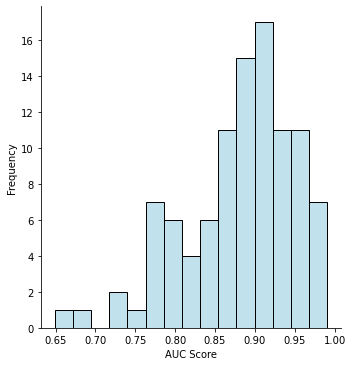

In [65]:
#from the 10 best models, 100 aucs in a histogram
sns.displot(auc_list, bins = 15, color='lightblue')
plt.xlabel('AUC Score')
plt.ylabel('Frequency')
# plt.title('Nested Cross Validation AUC Scores', fontsize = 15)

#median = 0.882
#mean = 0.880
plt.savefig('cutoff analysis/zero auc scores')

In [9]:
#100 iterations using random state and 10 best params
#for each best param, do 10 predictions using random states

data = no_cutoff
param_dict = sorted(param_top_ten, key = lambda x: x[1])[-10:]
prediction_matrix = pd.DataFrame(original_clean.reset_index()['species'])  
models_list_proven = []

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': int(param_dict[x][0]['n_estimators']),
                              'scale_pos_weight': int(param_dict[x][0]['scale_pos_weight']), 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    
    for u in range(10):
        X, y = data.iloc[:,:-1], data.iloc[:,-1]
        #stratify to make sure the 1s are distributed evenly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
        
        model = XGBClassifier(**params, booster='gbtree', objective='binary:logistic', eval_metric = 'logloss', use_label_encoder=False)
        model.fit(X_train, y_train)
        
        models_list_proven.append(model)

        #predictions in an array
        y = model.predict_proba(X)

        #match prediction to the species for this split
        probability_table = X.reset_index() #get the species in the test set
        probability_table['probability'] = pd.DataFrame(pd.DataFrame(y)[1]) #get the probabilities
        probability_table = probability_table[['species', 'probability']]
        #put the prediction in the big df
        for a in range(len(prediction_matrix)):
            for b in range(len(probability_table)):
                if prediction_matrix.loc[a, 'species'] == probability_table.loc[b, 'species']:
                    prediction_matrix.loc[a, str(x) + '.' + str(u)] = probability_table.loc[b, 'probability']

In [10]:
#get a prediction table with the median probability and percentile for each species
prediction_matrix['std'] = pd.DataFrame(prediction_matrix.std(axis=1))
prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.median(axis=1))
top_predictions = prediction_matrix
top_predictions['percentile'] = top_predictions.probability.rank(pct=True)

#these are the sandflies where the probability its a vector is greater than 0.5
#top_predictions = top_predictions[top_predictions['probability'] >= 0.5].reset_index(drop=True)

#get the important stats only
top_predictions = top_predictions[['species', 'probability','std', 'percentile']].reset_index(drop=True)

#add real labels
top_predictions = getstatus(top_predictions, 'leish')
top_predictions = top_predictions.fillna(0)

#sort by probability
final_predictions = top_predictions.sort_values(by ='probability', ascending=False).reset_index(drop=True)
final_predictions = final_predictions.round(3)
final_predictions

,species,probability,std,percentile,potential/proven
0,Bichromomyia flaviscutellata,0.943,0.050,1.000,2.0
1,Nyssomyia whitmani,0.917,0.044,0.998,2.0
2,Psychodopygus carrerai,0.916,0.055,0.996,2.0
3,Nyssomyia intermedia,0.914,0.043,0.994,2.0
4,Psathyromyia (Psathyromyia) shannoni,0.912,0.066,0.992,2.0
...,...,...,...,...,...
507,Evandromyia (Evandromyia) wilsoni,0.057,0.033,0.011,0.0
508,Brumptomyia orlandoi,0.056,0.037,0.006,0.0
509,Brumptomyia mangabeirai,0.056,0.037,0.006,0.0
510,Brumptomyia bragai,0.056,0.037,0.006,0.0


In [11]:
#save the final predictions
final_predictions.to_csv("cutoff analysis/zero all predictions.csv")

In [22]:
#get new predicted
new_predicted = final_predictions[final_predictions['potential/proven']!=2]
new_predicted = new_predicted[new_predicted['probability'] >= 0.5]
new_predicted
#how many non vectors did it predict to be a vector?
# len(d[d['probability'] >= 0.5]) = 19

,species,probability,std,percentile,potential/proven
19,Psychodopygus amazonensis,0.847,0.085,0.963,1.0
21,Nyssomyia antunesi,0.839,0.089,0.959,1.0
24,Psychodopygus guyanensis,0.803,0.113,0.953,0.0
26,Psychodopygus claustrei,0.798,0.091,0.949,0.0
29,Pintomyia (Pintomyia) pessoai,0.787,0.150,0.943,1.0
32,Trichophoromyia auraensis,0.761,0.154,0.938,1.0
34,Psathyromyia (Psathyromyia) bigeniculata,0.739,0.111,0.934,0.0
39,Psychodopygus chagasi,0.646,0.167,0.924,0.0
41,Trichophoromyia castanheirai,0.598,0.170,0.920,0.0
42,Psathyromyia (Psathyromyia) lanei,0.598,0.169,0.918,0.0


In [20]:
#save the csv
new_predicted.to_csv("cutoff analysis/zero new predictions.csv")

In [23]:
#takes in modelslist created in the predtable function, returns dataframe of variables and importances
def var_impt(list_of_models):

    impt_matrix = pd.DataFrame(list_of_models[0].feature_importances_, original_clean.columns[0:93])
    for x in range(1, len(list_of_models)):
        var_array = pd.DataFrame(list_of_models[x].feature_importances_, original_clean.columns[0:93])
        impt_matrix[x] = var_array[0]
        
    var_impt_df = pd.DataFrame()
    var_impt_df['feature'] = original_clean.columns[0:81]
    var_impt_df = var_impt_df.set_index('feature')
    for var in original_clean.columns[0:81]:
        mean = impt_matrix.loc[var].mean()
        var_impt_df.loc[var, 'importance'] = mean
        std = impt_matrix.loc[var].std()
        var_impt_df.loc[var, 'std'] = std

    var_impt_df = var_impt_df.reset_index()
    
    return impt_matrix, var_impt_df.round(3).sort_values(by='importance', ascending=False)

In [24]:
var_impt_conf = var_impt(models_list_proven)[1]
var_impt_conf['lower'] = var_impt_conf['importance'] - 1.96 * var_impt_conf['std'] / 10
var_impt_conf['higher'] = var_impt_conf['importance'] + 1.96 * var_impt_conf['std'] / 10

In [26]:
var_impt_conf.reset_index(drop=True).to_csv("cutoff analysis/zero variable importance all.csv")

In [25]:
var_impt_conf.head(25)

,feature,importance,std,lower,higher
38,citations,0.188,0.139,0.160756,0.215244
53,canopy,0.108,0.097,0.088988,0.127012
51,flii,0.053,0.088,0.035752,0.070248
67,genus_Bichromomyia,0.051,0.038,0.043552,0.058448
54,ghm,0.045,0.049,0.035396,0.054604
80,genus_Pintomyia,0.042,0.036,0.034944,0.049056
42,no.lat.teeth,0.041,0.043,0.032572,0.049428
62,ecoregion.breadth,0.032,0.037,0.024748,0.039252
30,semi.domestic,0.030,0.045,0.021180,0.038820
49,temp.range,0.028,0.029,0.022316,0.033684


## 20 percent cutoff

In [5]:
# remove: hs.canopy, hs.floor, peri, bites.man, bites.mammals, order.notes, labruml_wingl
#         A3_wingl, dental.depth, wing.width
    
original = pd.read_csv('raw data/one hot encoded original data.csv')
original = original.drop(columns=['Argentina', 'Belize','Bolivia', 'Brazil', 'Canada', 'CaymanIslands', 'Chile', 'Colombia',
                                  'Costa.Rica', 'Cuba', 'Dominican.Republic', 'Ecuador', 'El.Salvador', 'French.Guiana',
                                  'Guadeloupe', 'Guatemala', 'Grenada', 'Guyana', 'Haiti', 'Honduras', 'Jamaica','Martinica', 
                                  'Mexico', 'Nicaragua', 'Panama', 'Paraguay','PuertoRico', 'Peru', 'Suriname',
                                  'TrinidadTobago', 'Uruguay', 'USA', 'Venezuela','VirginIslands'])
status = pd.read_csv('raw data/sandfly status.csv')
#if sandfly is a proven vector for any species of leish, mark it in a new column 'cl' as 1
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 1

#get cleaned train datasets in a list
parasite = 'leish'
for j in range(len(original)):
    for i in range(len(status)):
        if original.loc[j, 'species'] == status.loc[i, 'species']:
            original.loc[j, parasite] = status.loc[i, parasite]

#fill the remaining vector status column with 0s, then binarize the status
original[parasite] = original[parasite].fillna(0).map(lambda x : x//2)
#set the index as the species name
original = original.set_index('species', drop=True)
#drop unnecessary columns
original = original.drop(columns=['Unnamed: 0', 'bites.man'])

####LOOK AT CORRELLATED VARIABLES
#tribe_Hertigiini is corr w 'genus_Warileya'
#subtribe_hertigiina is corr w 'genus_Warileya'
#peri is corr w semi.domestic
#'genus_Brumptomyia' is corr w 'subtribe_Brumptomyiina'
#'genus_Micropygomyia' is corr w 'subtribe_Sergentomyiina'

#wing_width / hs.canopy
#wing_width / hs.floor
#labruml_wingl / log.labrum.length
#log.grass.cover / log.shrub.cover
#domestic / intra
#wing.width/temp 
#log.elevation / temp
#log.temp.var / temp.range
#maxshape_sabre / genus_Brumptomyia
#log.dental.depth / log.labrum.length

twenty_cutoff = original.drop(columns=['subtribe_Sergentomyiina', 'subtribe_Brumptomyiina',
                                              'peri', 'subtribe_Hertigiina', 'tribe_Hertigiini',
                                              'wing.width', 'labruml_wingl', 'log.shrub.cover',
                                              'intra', 'log.elevation', 'log.temp.var', 'maxshape_sabre', 'log.dental.depth',
                                       'hs.canopy', 'hs.floor', 'peri', 'bites.mammals',
                                        'labruml_wingl', 'A3_wingl', 'wing.width'])


In [6]:
twenty_cutoff.columns

Index(['b.tsmbf', 'b.tsdbf', 'b.tsgss', 'b.mangrove', 'b.fgs', 'b.dxs',
       'b.tscf', 'b.tgss', 'b.tcforest', 'b.tbmforest', 'b.montane', 'mh.flfs',
       'mh.ab', 'mh.bwa', 'mh.tttr', 'mh.th', 'mh.tt', 'mh.cr', 'mh.ca',
       'mh.fwsl', 'mh.ma', 'mh.ada', 'mh.oihd', 'wild', 'semi.domestic',
       'domestic', 'no.lat.teeth', 'wing.length', 'wingl_wingw', 'temp',
       'temp.range', 'flii', 'canopy', 'ghm', 'evi', 'tribe_Phlebotomini',
       'subtribe_Lutzomyiina', 'subtribe_Psychodopygina', 'genus_Bichromomyia',
       'genus_Brumptomyia', 'genus_Dampfomyia', 'genus_Deanemyia',
       'genus_Evandromyia', 'genus_Expapillata', 'genus_Hertigia',
       'genus_Lutzomyia', 'genus_Martinsmyia', 'genus_Micropygomyia',
       'genus_Migonemyia', 'genus_Nyssomyia', 'genus_Oligodontomyia',
       'genus_Pintomyia', 'genus_Pressatia', 'genus_Psathyromyia',
       'genus_Psychodopygus', 'genus_Sciopemyia', 'genus_Trichophoromyia',
       'genus_Trichopygomyia', 'genus_Viannamyia', 'genus_

In [55]:
### get out a list *primary_parameters* that has the parameters and aucs

for i in range(100):
    data = twenty_cutoff
    do_nested_cv(data)

100%|██████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23trial/s, best loss: 0.2198412698412698]
Final Test Score is 0.8020833333333334
best = {'a': 0, 'colsample_bytree': 0.5867805713801237, 'gamma': 108.95283712600491, 'learning_rate': 0.43782796952587294, 'max_depth': 9.993787277467646, 'n_estimators': 145.29964238191684, 'scale_pos_weight': 13.427124986250638}
100%|█████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08trial/s, best loss: 0.15655929038281977]
Final Test Score is 0.7983630952380952
best = {'a': 0, 'colsample_bytree': 0.8332631165251473, 'gamma': 10.381728652240266, 'learning_rate': 0.2782579685915095, 'max_depth': 5.939815473524851, 'n_estimators': 133.3259035500546, 'scale_pos_weight': 11.916282185253392}
100%|█████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33trial/s, best loss: 0.22777777777777777]
Final Test Score is 0.8645833333333334
best = {'a': 0, 'colsample_bytree': 0.6886055155610311, 'gamma'

100%|██████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07trial/s, best loss: 0.1505368814192343]
Final Test Score is 0.7983630952380952
best = {'a': 0, 'colsample_bytree': 0.3575509132982135, 'gamma': 10.191440531011976, 'learning_rate': 0.4859353258902357, 'max_depth': 4.409359414552409, 'n_estimators': 199.33306519750982, 'scale_pos_weight': 11.665141087363214}
100%|██████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08trial/s, best loss: 0.2953781512605042]
Final Test Score is 0.8229166666666666
best = {'a': 0, 'colsample_bytree': 0.8379870467599356, 'gamma': 12.523167665014025, 'learning_rate': 0.27987095810206175, 'max_depth': 6.123397168555185, 'n_estimators': 174.97684513337302, 'scale_pos_weight': 13.22684248052381}
100%|█████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28trial/s, best loss: 0.11673669467787111]
Final Test Score is 0.875
best = {'a': 0, 'colsample_bytree': 0.22132818981613678, 'gamma': 11.6749628

100%|█████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04trial/s, best loss: 0.10700280112044813]
Final Test Score is 0.7008928571428572
best = {'a': 0, 'colsample_bytree': 0.7574195594108922, 'gamma': 54.05930118163323, 'learning_rate': 0.6889178159962227, 'max_depth': 4.197907024422029, 'n_estimators': 156.10188410340203, 'scale_pos_weight': 8.709448216787472}
100%|██████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/trial, best loss: 0.1803688141923436]
Final Test Score is 0.7760416666666666
best = {'a': 0, 'colsample_bytree': 0.2504695070758127, 'gamma': 91.44483358042638, 'learning_rate': 0.16000035549756686, 'max_depth': 9.845506358103096, 'n_estimators': 152.86420799668036, 'scale_pos_weight': 13.48056304081369}
100%|█████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34trial/s, best loss: 0.23760504201680666]
Final Test Score is 0.7254464285714286
best = {'a': 0, 'colsample_bytree': 0.6233050609913772, 'gamma': 6

100%|█████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/trial, best loss: 0.27156862745098037]
Final Test Score is 0.7254464285714286
best = {'a': 0, 'colsample_bytree': 0.2865975918004906, 'gamma': 82.7728624590299, 'learning_rate': 0.6085343449018792, 'max_depth': 8.925784908722774, 'n_estimators': 148.72300999940296, 'scale_pos_weight': 6.873902020799582}
100%|██████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50trial/s, best loss: 0.2572362278244631]
Final Test Score is 0.7529761904761905
best = {'a': 0, 'colsample_bytree': 0.5021420573064197, 'gamma': 10.854930375590552, 'learning_rate': 0.5085943724168935, 'max_depth': 8.272738185545006, 'n_estimators': 194.50670502150243, 'scale_pos_weight': 9.606395029206652}
100%|█████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29trial/s, best loss: 0.22994864612511667]
Final Test Score is 0.777529761904762
best = {'a': 0, 'colsample_bytree': 0.2805265958620792, 'gamma': 19.

100%|█████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31trial/s, best loss: 0.23783846872082168]
Final Test Score is 0.8191964285714286
best = {'a': 0, 'colsample_bytree': 0.2430135762261464, 'gamma': 17.03315269066094, 'learning_rate': 0.5302402092275345, 'max_depth': 8.72276920861869, 'n_estimators': 190.31518163000703, 'scale_pos_weight': 9.892457476921205}
100%|█████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33trial/s, best loss: 0.20422502334267043]
Final Test Score is 0.7671130952380951
best = {'a': 0, 'colsample_bytree': 0.3984062391959654, 'gamma': 12.886008429126946, 'learning_rate': 0.2226991959929353, 'max_depth': 7.014770510944542, 'n_estimators': 147.58049992598905, 'scale_pos_weight': 7.63615116977031}
100%|██████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35trial/s, best loss: 0.2736694677871148]
Final Test Score is 0.8697916666666666
best = {'a': 0, 'colsample_bytree': 0.3613515827871645, 'gamma': 15.

100%|█████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38trial/s, best loss: 0.24180672268907558]
Final Test Score is 0.828125
best = {'a': 0, 'colsample_bytree': 0.8327343799168938, 'gamma': 52.74541161958407, 'learning_rate': 0.8137837202182372, 'max_depth': 1.466896272595781, 'n_estimators': 196.914230090025, 'scale_pos_weight': 10.841948464484464}
100%|█████████████████████████████████████████████| 100/100 [01:03<00:00,  1.59trial/s, best loss: 0.19810924369747898]
Final Test Score is 0.6956845238095237
best = {'a': 0, 'colsample_bytree': 0.566689121431845, 'gamma': 56.06364298252803, 'learning_rate': 0.4845931432115631, 'max_depth': 6.387605009759963, 'n_estimators': 196.44089861880437, 'scale_pos_weight': 11.685368371881262}
100%|█████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15trial/s, best loss: 0.18036881419234355]
Final Test Score is 0.7514880952380952
best = {'a': 0, 'colsample_bytree': 0.7296556352790573, 'gamma': 55.4440134124

100%|██████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32trial/s, best loss: 0.2040849673202614]
Final Test Score is 0.777529761904762
best = {'a': 0, 'colsample_bytree': 0.2637970982919025, 'gamma': 11.240451375729467, 'learning_rate': 0.4006278434810974, 'max_depth': 6.432521141412574, 'n_estimators': 186.17642795488538, 'scale_pos_weight': 6.1580093909671145}
100%|█████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38trial/s, best loss: 0.27759103641456584]
Final Test Score is 0.8452380952380952
best = {'a': 0, 'colsample_bytree': 0.8036775271492014, 'gamma': 11.763969083474265, 'learning_rate': 0.933511148449893, 'max_depth': 1.3263439632543688, 'n_estimators': 173.39085128985312, 'scale_pos_weight': 6.764027001954091}
100%|██████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58trial/s, best loss: 0.2499299719887956]
Final Test Score is 0.8645833333333334
best = {'a': 0, 'colsample_bytree': 0.6711756372732298, 'gamma': 

100%|█████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52trial/s, best loss: 0.13851540616246494]
Final Test Score is 0.875
best = {'a': 0, 'colsample_bytree': 0.6360600744141591, 'gamma': 13.729722640459583, 'learning_rate': 0.4373269349275076, 'max_depth': 5.85218998744063, 'n_estimators': 127.68814564050044, 'scale_pos_weight': 12.109015732476148}
100%|█████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67trial/s, best loss: 0.21211484593837537]
Final Test Score is 0.8333333333333334
best = {'a': 0, 'colsample_bytree': 0.6453930318293479, 'gamma': 10.31311708745031, 'learning_rate': 0.4148272639576834, 'max_depth': 1.9918630096728194, 'n_estimators': 100.17285378585045, 'scale_pos_weight': 9.733713164114654}
100%|██████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24trial/s, best loss: 0.2181605975723623]
Final Test Score is 0.8489583333333334
best = {'a': 0, 'colsample_bytree': 0.2889485597605909, 'gamma': 21.5190069950

In [56]:
# create a binary pickle file 
f = open("cutoff analysis/twenty parameters.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(primary_parameters,f)

# close file
f.close()

In [7]:
twenty_parameters = pd.read_pickle(r'cutoff analysis/twenty parameters.pkl')

In [8]:
# take these parameters to R
param_top_ten = sorted(twenty_parameters, key = lambda x: x[1])[-10:]
params = [a[0] for a in param_top_ten]
param_df = pd.DataFrame(params).drop(columns = ['a'])
param_df.to_csv('cutoff analysis/twenty top 10 parameters.csv')

In [9]:
####
#FOR EACH OF THE 10 BEST PERFORMING PARAMETERS IN ORIGINAL_MODELS, DO EVALUATIONS ON 10 RANDOM STATE SPLITS
####

param_dict = param_top_ten
auc_list = []
data = twenty_cutoff

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': int(param_dict[x][0]['n_estimators']),
                              'scale_pos_weight': int(param_dict[x][0]['scale_pos_weight']), 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    X = data.iloc[:,:-1] # Feature matrix in pd.DataFrame format
    y = data.iloc[:,-1] # Target vector in pd.Series format
    
    for q in range(10):

        # Making train and test sets for both X and y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

        # Instantiate an XGBoost object with hyperparameters
        xgb_clf = xgb.XGBClassifier(**params,
                                    objective='binary:logistic', booster='gbtree', 
                                    n_jobs=2, eval_metric = 'logloss', use_label_encoder=False)

        # Train the model with train data sets
        xgb_clf.fit(X_train, y_train)

        prob = np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])
        for x in range(len(prob)):
            if prob[x] > np.mean(np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])):
                prob[x] = 1
            else:
                prob[x] = 0

        y_pred = prob
        y_true = y_test # True values

#         print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

        auc_list.append(roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]))

        #less ugly step curve
#         plot_roc_curve(xgb_clf, X_test, y_test, color='lightgrey', ax=ax)

# ax.get_legend().remove()
# print(auc_list)
print('median AUC: ' + str(np.median(auc_list)))
print('mean AUC: ' + str(np.mean(auc_list)))

KeyboardInterrupt: 

In [60]:
from scipy.stats import sem
print("standard error", sem(auc_list))
print("std", np.std(auc_list, ddof=1))

standard error 0.007871751025696757
std 0.07871751025696758


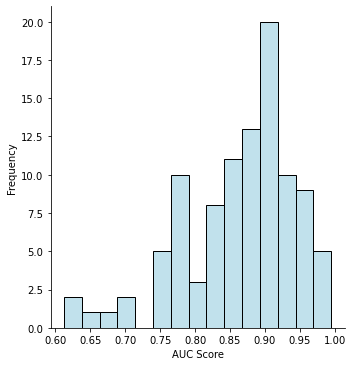

In [61]:
#from the 10 best models, 100 aucs in a histogram
sns.displot(auc_list, bins = 15, color='lightblue')
plt.xlabel('AUC Score')
plt.ylabel('Frequency')
# plt.title('Nested Cross Validation AUC Scores', fontsize = 15)

#median = 0.882
#mean = 0.880
plt.savefig('cutoff analysis/twenty auc scores')

In [12]:
#100 iterations using random state and 10 best params
#for each best param, do 10 predictions using random states

data = twenty_cutoff
param_dict = sorted(param_top_ten, key = lambda x: x[1])[-10:]
prediction_matrix = pd.DataFrame(original_clean.reset_index()['species'])  
models_list_proven = []

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': int(param_dict[x][0]['n_estimators']),
                              'scale_pos_weight': int(param_dict[x][0]['scale_pos_weight']), 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    
    for u in range(10):
        X, y = data.iloc[:,:-1], data.iloc[:,-1]
        #stratify to make sure the 1s are distributed evenly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
        
        model = XGBClassifier(**params, booster='gbtree', objective='binary:logistic', eval_metric = 'logloss', use_label_encoder=False)
        model.fit(X_train, y_train)
        
        models_list_proven.append(model)

        #predictions in an array
        y = model.predict_proba(X)

        #match prediction to the species for this split
        probability_table = X.reset_index() #get the species in the test set
        probability_table['probability'] = pd.DataFrame(pd.DataFrame(y)[1]) #get the probabilities
        probability_table = probability_table[['species', 'probability']]
        #put the prediction in the big df
        for a in range(len(prediction_matrix)):
            for b in range(len(probability_table)):
                if prediction_matrix.loc[a, 'species'] == probability_table.loc[b, 'species']:
                    prediction_matrix.loc[a, str(x) + '.' + str(u)] = probability_table.loc[b, 'probability']

In [63]:
#get a prediction table with the median probability and percentile for each species
prediction_matrix['std'] = pd.DataFrame(prediction_matrix.std(axis=1))
prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.median(axis=1))
top_predictions = prediction_matrix
top_predictions['percentile'] = top_predictions.probability.rank(pct=True)

#these are the sandflies where the probability its a vector is greater than 0.5
#top_predictions = top_predictions[top_predictions['probability'] >= 0.5].reset_index(drop=True)

#get the important stats only
top_predictions = top_predictions[['species', 'probability','std', 'percentile']].reset_index(drop=True)

#add real labels
top_predictions = getstatus(top_predictions, 'leish')
top_predictions = top_predictions.fillna(0)

#sort by probability
final_predictions = top_predictions.sort_values(by ='probability', ascending=False).reset_index(drop=True)
final_predictions = final_predictions.round(3)
final_predictions

,species,probability,std,percentile,potential/proven
0,Bichromomyia flaviscutellata,0.941,0.083,1.000,2.0
1,Nyssomyia intermedia,0.910,0.083,0.998,2.0
2,Psychodopygus davisi,0.909,0.085,0.996,2.0
3,Nyssomyia whitmani,0.904,0.073,0.994,2.0
4,Psathyromyia (Psathyromyia) shannoni,0.903,0.109,0.992,2.0
...,...,...,...,...,...
507,Brumptomyia bragai,0.036,0.031,0.012,0.0
508,Evandromyia (Evandromyia) wilsoni,0.036,0.032,0.006,0.0
509,Evandromyia (Barrettomyia) costalimai,0.036,0.032,0.006,0.0
510,Evandromyia (Barrettomyia) callipyga,0.036,0.032,0.006,0.0


In [64]:
#save the final predictions
final_predictions.to_csv("cutoff analysis/twenty all predictions.csv")

In [65]:
#get new predicted
new_predicted = final_predictions[final_predictions['potential/proven']!=2]
new_predicted = new_predicted[new_predicted['probability'] >= 0.5]
new_predicted
#how many non vectors did it predict to be a vector?
# len(d[d['probability'] >= 0.5]) = 19

,species,probability,std,percentile,potential/proven
17,Nyssomyia antunesi,0.849,0.089,0.967,1.0
18,Psychodopygus amazonensis,0.837,0.116,0.965,1.0
22,Psychodopygus claustrei,0.797,0.156,0.957,0.0
27,Pintomyia (Pintomyia) pessoai,0.769,0.198,0.947,1.0
29,Psychodopygus guyanensis,0.755,0.186,0.943,0.0
32,Psathyromyia (Psathyromyia) bigeniculata,0.741,0.164,0.938,0.0
37,Trichophoromyia auraensis,0.725,0.159,0.928,1.0
39,Sciopemyia sordellii,0.615,0.238,0.924,1.0
41,Psychodopygus chagasi,0.563,0.207,0.920,0.0
42,Evandromyia (Evandromyia) infraspinosa,0.552,0.214,0.918,0.0


In [66]:
#save the csv
new_predicted.to_csv("cutoff analysis/twenty new predictions.csv")

In [27]:
#takes in modelslist created in the predtable function, returns dataframe of variables and importances
def var_impt(list_of_models):

    impt_matrix = pd.DataFrame(list_of_models[0].feature_importances_, twenty_cutoff.columns[0:77])
    for x in range(1, len(list_of_models)):
        var_array = pd.DataFrame(list_of_models[x].feature_importances_, twenty_cutoff.columns[0:77])
        impt_matrix[x] = var_array[0]
        
    var_impt_df = pd.DataFrame()
    var_impt_df['feature'] = twenty_cutoff.columns[0:77]
    var_impt_df = var_impt_df.set_index('feature')
    for var in twenty_cutoff.columns[0:77]:
        mean = impt_matrix.loc[var].mean()
        var_impt_df.loc[var, 'importance'] = mean
        std = impt_matrix.loc[var].std()
        var_impt_df.loc[var, 'std'] = std

    var_impt_df = var_impt_df.reset_index()
    
    return impt_matrix, var_impt_df.round(3).sort_values(by='importance', ascending=False)

In [28]:
var_impt_conf = var_impt(models_list_proven)[1]
var_impt_conf['lower'] = var_impt_conf['importance'] - 1.96 * var_impt_conf['std'] / 10
var_impt_conf['higher'] = var_impt_conf['importance'] + 1.96 * var_impt_conf['std'] / 10

In [29]:
var_impt_conf.reset_index(drop=True).to_csv("cutoff analysis/twenty variable importance all.csv")